This notebooks goal is to generalize the `afterburner` function that was already created for the PyTorch model to the Numpy version.

The high level idea behind the afterburner function is to run inference on **2k** x **2k** sub-images of the larger **6k** by **6k** images. This is done a total of 21 times.

To see where the 21 times comes from we need to break down what the `afterburner` function does:

1. Runs inference over the whole image, by segmenting the 6k image into smaller 2k pieces. Therefore, we'll get 9 unique grid cells due to the fact that it takes **9** 2k by 2k images to equal the full 6k by 6k image. Ex (must open markdown cell to see the images in correct format.):

$$
+------------+                  
|            |                  
|            |
|            |        
|            |     
|            |
|            |
+------------+
$$
goes to 
$$
+----+----+----+                  
|    |    |    |                       
|    |    |    |                       
+----+----+----+                      
|    |    |    |                       
|    |    |    |                       
+----+----+----+
$$

2. Runs inference over the overlapping vertical directions. Due to the segmentation applied over the whole image in (1.) the borders between 2k sub-images might have sharp discontinuities due to the model denoising the image in slightly different ways due to not having the larger spatial information near the borders. To remedy this it runs inference over the overlapping vertical directions. Those would be the interior columns of the second grid image. This will produce **6** extra inference calls. That is centering the window at the center of the long-dashed lines and moving down by 1000 pixels (default) 3 times per column.

3. Runs inference over the overlapping horizontal directions. This is done due to the same reason as the (2.) but now the inference windows are centered around the interior (middle row).

4. Add up all the pixel values and divide by the counts (ie. the number of times a pixel had inferenced ran on them). This effectively gets the average of the number of inference runs on the image effectively ridding of the potentials for the sharp discontinuities.

# `afterburner` using PyTorch

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import numpy as np 
import pathlib

# Importing utitility functions for training
from PT_files.model import DnCNN_2k, DnCNN_B, DnCNN
from PT_files.Dataset import Img_Dataset, Large_Img_Dataset
from PT_files.afterburner_torch import afterburner
import PT_files.preprocess_data as ppd
import PT_files.save_load as sl
import matplotlib.pyplot as plt
import os


device = "cuda" if torch.cuda.is_available() else "cpu"

Using cuda device


In [2]:
# Loading data & weights dictionary

PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()
# name = '6k_model_wb_e800_lys20_58feat.pth'
name = '2k_model_bs64_e800_ps50_Adam.pth'
# weights = np.load(DATA / name)
weights = torch.load(str(DATA / name))


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

# samp = sample[0][0][1000:3000, 1000:3000]
# samp = samp.reshape((1, 1, 2000, 2000))
samp = sample[0][0]

Shape of test set= (108, 1, 6000, 6000)


The function takes the whole test data. This needs to be fixed to just give it a single 6k by 6k image and run the `afterburner` on this. This will require some tweaking of the current script to be able to run.

**ALSO:** Want to get this working agnostically with the Numpy version of the model.
- This will require making the Numpy model into a script and then further generalizing the `afterburner` function

`afterburner` version that works on PyTorch takes ~14s.

In [5]:
denoised_2k = afterburner(dataset=test_data, model=DnCNN_B,  model_params='2k_model_bs64_e800_ps50_Adam.pth', samp_idx=0)

Beginning of Afterburner function
Run finished
Run finished
Run finished
Run finished
Run finished
Run finished
Vertical pass completed
Run finished
Run finished
Run finished
Run finished
Run finished
Run finished
Horizontal pass completed
Run finished
Run finished
Run finished
Run finished
Run finished
Run finished
Run finished
Run finished
Run finished
Full img pass completed


In [6]:
denoised_2k.shape

(1, 1, 6000, 6000)

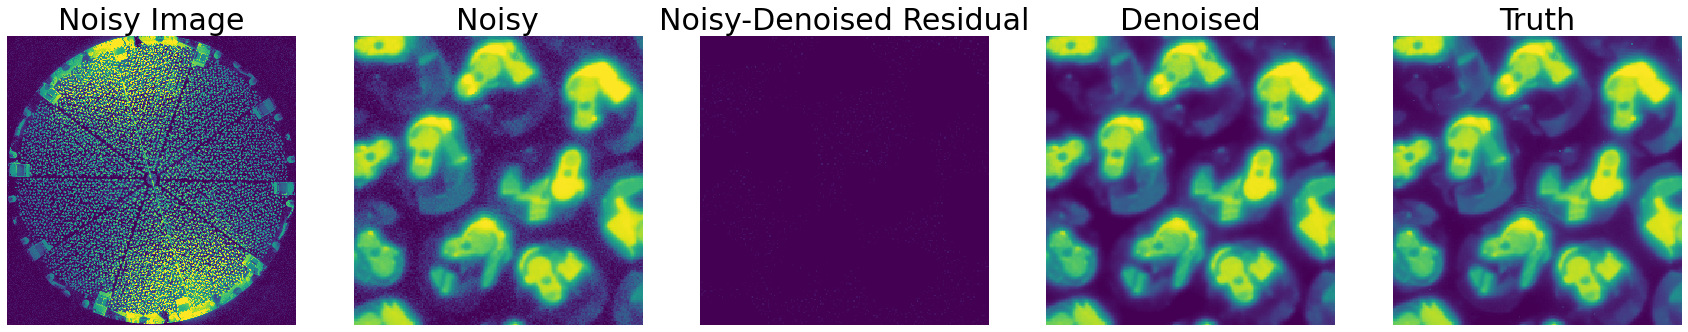

In [12]:
def plot_comparison(raw_data,
                    inf_data,
                    size,
                    start_idx,
                    end_idx):
    
    data_6k_raw = raw_data[0][0][0][start_idx:end_idx, start_idx:end_idx]
    data_6k_truth = raw_data[1][0][0][start_idx:end_idx, start_idx:end_idx]

    full_img_inf = inf_data[0][0][start_idx:end_idx, start_idx:end_idx]
    
    assert size == end_idx-start_idx
    
    
    fig, ax = plt.subplots(1, 5,figsize=(30, 26))
    vmin, vmax = np.percentile(data_6k_raw, (1,99))

    # NOTE: to display the FP in the correct orientation origin='upper',
    # while usually I set it to 'lower'. 
    # Ask David/figure out why this is.
    ax[0].imshow(raw_data[0][0][0], vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[0].axis('off')
    ax[0].set_title('Noisy Image', fontsize=30) 
    ax[1].imshow(data_6k_raw, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[1].axis('off')
    ax[1].set_title('Noisy',fontsize=30) 
    ax[2].imshow(np.abs(full_img_inf - data_6k_raw),vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[2].axis('off')
    ax[2].set_title('Noisy-Denoised Residual', fontsize=30)
    ax[3].imshow(full_img_inf, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[3].axis('off')
    ax[3].set_title('Denoised',fontsize=30) 
    ax[4].imshow(data_6k_truth, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[4].axis('off')
    ax[4].set_title('Truth', fontsize=30)
    
plot_comparison(raw_data=test_data,
                inf_data=denoised_2k,
                size=200,
                start_idx=1400,
                end_idx=1600)

# `afterburner` using NumPy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib 
import os
import pickle
import torch

import PT_files.save_load as sl
from DnCNN_NP.layers_np import relu, np_BatchNorm2d, np_Conv2d
from DnCNN_NP.model_np import np_DnCNN

import time 
import pdb

In [2]:
# Loading data & weights dictionary

PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()
# name = '6k_model_wb_e800_lys20_58feat.pth'
name = '2k_model_bs64_e800_ps50_Adam.pth'
# weights = np.load(DATA / name)
weights = torch.load(str(DATA / name))


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

samp = sample[0][0][1000:3000, 1000:3000]
samp = samp.reshape((1, 1, 2000, 2000))

samp_6k = sample[0]
samp_6k = np.reshape(samp_6k, (1, 1, 6000, 6000))


Shape of test set= (108, 1, 6000, 6000)


In [3]:
im2col_mat = sl.NERSC_load(name='im2col_layer_dict_2k.pkl')
im2col_layer_list = sl.NERSC_load(name='2k_NP_layers_list.pkl')

In [4]:
denoised_np = np_DnCNN(input_data=samp, 
                       weights_dict=weights, 
                       layer_list=im2col_layer_list, 
                       im2col_mat=im2col_mat)

**Work for tomorrow:**

1. Get `grid_window` working for numpy version - **Done**
    - See why there's a UnboundLocalError
    - The `height` variable is definitely called before being used because it's created with the unpacking of the data shape via the `if/elif` statements...or so I thought?
2. Once `grid_window` is working get the rest of the afterburner functions working
    - **Should probably load in the `model_params`, `layer_lists`, and `im2col_mat` before using `grid_window` or any other afterburner functions.**
        - This will save a lot of time due to how large these are and how **often** they will be called.
3. Create master function that allows the user to call the `numpy` or `pytorch` version of the afterburner function
    - NOTE: CLEAN UP THE DOCUMENTATION OF THE `afterburner` function
        - Also GENUINELY consider rewriting the whole function because it is very poorly written and really hard to understand. Maybe adding visuals would be helpful?
        
        
Potentially update the sliding window functions to use the iterators for cleaner implementation. Need to figure out how to implement that and also how to get the indices for the H/W= [start, end], respectively. 

In [5]:
def grid_window(data,
                model,
                weights_dict,
                layer_list,
                im2col_mat,
                h_start,
                h_end,
                w_start,
                w_end):
    
    """
    Function to calculate a specified sized inference window.
    
    Parameters:
    -----------
    dataset: np.array
        Dataset of coupled noisy & clean images of full 6k images
    model: Numpy model
        np_DnCNN
    model_params: str
        Models parameters for the 2k image trained model
    samp_idx: int
        Sample index to select which of the test images to be used for 
        inference
    h_start: int
        The height starting index of the inference window.
        E.g. It would be the origin for the y-coord in a 2-D plot
    h_end: int
        The height ending index of the inference window.
        E.g. It would be the end of the y-axis for the y-coord 
        in a 2-D plot
    w_start: int
        The horizontal starting index of the inference window.
        E.g. It would be the origin for the x-coord in a 2-D plot
    w_end: int
        The horizontal ending index of the inference window.
        E.g. It would be the end of the x-axis for the x-coord 
        in a 2-D plot
   
        
    Returns:
    --------
    full: np.array
        Array of the models output over the window region.
    count: np.array
        Array of 1's that keeps track of which pixels have had
        inferenced done upon them. This is so later on averaging can
        be done for pixels that had overlapping inference window
        calculations.
    """
    
    full = np.empty((1, 1, 6000, 6000))
    count = np.empty((1, 1, 6000, 6000))
    
    # There might be a problem here if we're indexing too many indices if we only have a single image.
    noise_data = data[:, :, h_start:h_end, w_start:w_end]   

    # Load the model with corresponding weights, layer lists, and im2col matrices
    # and run inference (ie. denoise the image)
    denoised_img = np_DnCNN(input_data=noise_data, 
                     weights_dict=weights_dict,
                     layer_list=layer_list,
                     im2col_mat=im2col_mat)
        
    # Keep the denoised pixels together + the number of times
    # specific pixels had inference ran on them
    full[:, :, h_start:h_end, w_start:w_end] += denoised_img
    count[:, :, h_start:h_end, w_start:w_end] += 1
        
        
    return full, count

In [6]:
%timeit full, count = grid_window(data=samp_6k, model=np_DnCNN,weights_dict=weights,layer_list=im2col_layer_list,im2col_mat=im2col_mat,h_start=1000,h_end=3000,w_start=1000,w_end=3000)

1min 44s ± 1.92 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
full, count = grid_window(data=samp_6k,
                          model=np_DnCNN,
                          weights_dict=weights,
                          layer_list=im2col_layer_list,
                          im2col_mat=im2col_mat,
                          h_start=1000,
                          h_end=3000,
                          w_start=1000,
                          w_end=3000)

In [8]:
inf_patch_size=2000
inf_patch_length = int(len(samp_6k[0][0][0]) / inf_patch_size)
print(inf_patch_length)

3


In [9]:
def full_img_pass(dataset,
                  model,
                  weights_dict,
                  layer_list,
                  im2col_mat,
                  window_size=2000):
    
    """
    Full inference pass. Ie. this goes over every single pixel
    within the entire 6k by 6k image
    
    Parameters:
    -----------
    dataset: np.array
        Dataset of coupled noisy & clean images of full 6k images
    model: Numpy model
        np_DnCNN
    weights_dict: Dict
        Dictionary of the weights for a 2k np_DnCNN model.
    window_size: int
        Width/height of the inference window that moves over the full 
        6k by 6k image. 
        Defaults to 2000, which means that each inference call is over a
        2000x2000 sub-image of the full 6000x6000 FVC image.
        
    Returns:
    --------
    full: np.array
        Array of the models output over the specified window regions.
    count: np.array
        Array of 1's that keeps track of which pixels have had
        inferenced done upon them. This is so later on averaging can
        be done for pixels that had overlapping inference window
        calculations.
    """
    
   
    inf_patch_size = window_size
    inf_patch_length = int(len(dataset[0][0][0]) / inf_patch_size)

    window_end_idx = []
    for k in range(inf_patch_length):
        window_end_idx.append(inf_patch_size*(k))
    window_end_idx.append(len(dataset[0][0][0])) # appends endpt ie. 6k

    # Full image pass
    full = np.zeros((1, 1, 6000, 6000))
    count = np.zeros((1, 1, 6000, 6000))

    for j in range(len(window_end_idx)-1):
        for i in range(len(window_end_idx)-1):

            full_c1, count_c1 = grid_window(data=dataset,
                                            model=model,
                                            weights_dict=weights_dict,
                                            layer_list=layer_list,
                                            im2col_mat=im2col_mat,
                                            h_start=window_end_idx[i],
                                            h_end=window_end_idx[i+1],
                                            w_start=window_end_idx[j],
                                            w_end=window_end_idx[j+1])

            full += full_c1
            count += count_c1
            print('Run finished.')
            
    return full, count

`full_img_pass`'s runtime is ~ 16m 40s

In [10]:
%timeit full, count = full_img_pass(dataset=samp_6k, model=np_DnCNN,weights_dict=weights, layer_list=im2col_layer_list,im2col_mat=im2col_mat)

Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
16min 

In [11]:
full, count = full_img_pass(dataset=samp_6k, 
                            model=np_DnCNN,
                            weights_dict=weights, 
                            layer_list=im2col_layer_list,
                            im2col_mat=im2col_mat)

Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.


In [12]:
np.allclose(full[:, :, 1000:3000, 1000:3000], denoised_np)

False

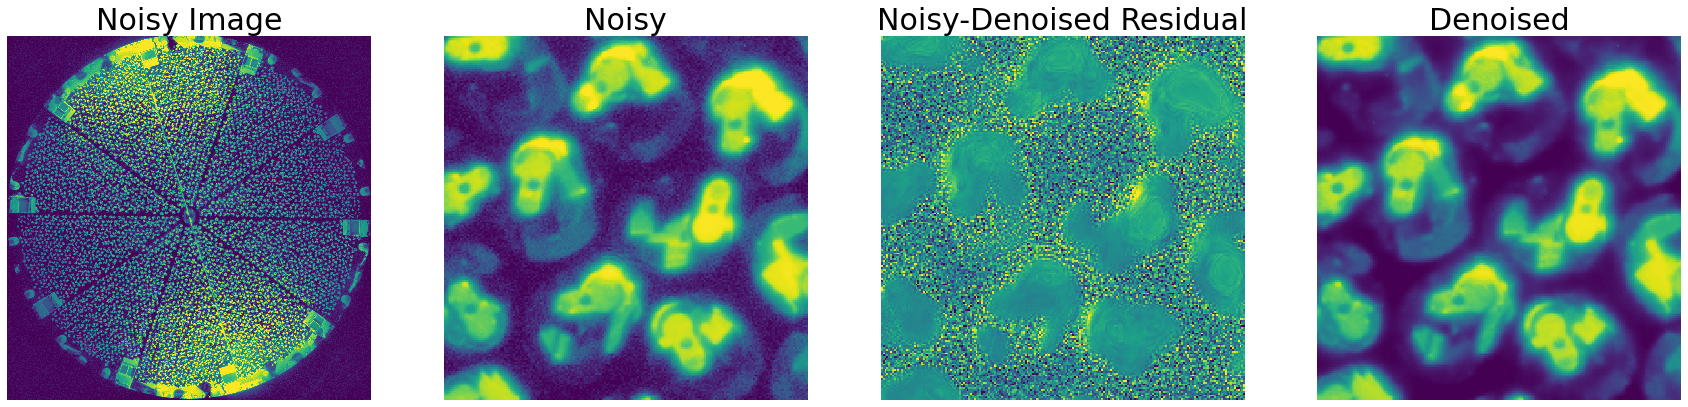

In [15]:
def plot_comparison(raw_data,
                    inf_data,
                    size,
                    start_idx,
                    end_idx):
    
    data_6k_raw = raw_data[0][0][start_idx:end_idx, start_idx:end_idx]
    # data_6k_truth = raw_data[1][0][start_idx:end_idx, start_idx:end_idx]

    full_img_inf = inf_data[0][0][start_idx:end_idx, start_idx:end_idx]
    
    assert size == end_idx-start_idx
    
    
    fig, ax = plt.subplots(1, 4,figsize=(30, 26))
    vmin, vmax = np.percentile(data_6k_raw, (1,99))
    # For residuals
    vmin_resid, vmax_resid = np.percentile((full_img_inf - data_6k_raw), (1,99))

    # NOTE: to display the FP in the correct orientation origin='upper',
    # while usually I set it to 'lower'. 
    # Ask David/figure out why this is.
    ax[0].imshow(raw_data[0][0], vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[0].axis('off')
    ax[0].set_title('Noisy Image', fontsize=30) 
    ax[1].imshow(data_6k_raw, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[1].axis('off')
    ax[1].set_title('Noisy',fontsize=30) 
    ax[2].imshow(full_img_inf - data_6k_raw, vmin=vmin_resid, vmax=vmax_resid, origin='upper', interpolation='none')
    ax[2].axis('off')
    ax[2].set_title('Noisy-Denoised Residual', fontsize=30)
    ax[3].imshow(full_img_inf, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[3].axis('off')
    ax[3].set_title('Denoised',fontsize=30) 
    # ax[4].imshow(data_6k_truth, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    # ax[4].axis('off')
    # ax[4].set_title('Truth', fontsize=30)
    
plot_comparison(raw_data=samp_6k,
                inf_data=full,
                size=200,
                start_idx=1400,
                end_idx=1600)

In [14]:
max(count)

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])

## Work on using an iterator to create the different sliding window protocols (ie. full, vertical, and horizontal passes)

In [104]:
def full_sliding_window(image, stepSize=2000, windowSize=(2000,2000)):
    """
    Creates iterator of sliding 2k by 2k windows over full 6k by 6k FVC image.
    This iterator covers the entire image once.
    """
    H, W = image.shape[-2], image.shape[-1]
    for y in range(0, H, stepSize):
        for x in range(0, W, stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def vert_sliding_window(image, stepSize=2000, offset=1000, windowSize=(2000,2000)):
    """
    Creates iterator of sliding 2k by 2k windows over central 4k pixels of the 
    FVC image (ie. H=[0, 6k] & W=[1k, 5k]). 
    """
    H, W = image.shape[-2], image.shape[-1]
    for y in range(0, H, stepSize):
        for x in range(offset, W - offset, stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
            
def horiz_sliding_window(image, stepSize=2000, offset=1000, windowSize=(2000,2000)):
    """
    Creates iterator of sliding 2k by 2k windows over middle 4k pixels of the 
    FVC image (ie. H=[1, 5k] & W=[0, 6k]). 
    """
    H, W = image.shape[-2], image.shape[-1]
    for y in range(offset, H-offset, stepSize):
        for x in range(0, W, stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
            
            
            
def sliding_windows(image, window_type):
    
    if str(window_type) == 'full':
        full = full_sliding_window(image=image)
        return full
    
    elif str(window_type) == 'vert':
        vert = vert_sliding_window(image=image)
        return vert
    
    elif str(window_type) == 'horiz':
        horiz = horiz_sliding_window(image=image)
        return horiz            

In [106]:
windows = sliding_windows(image=samp_6k, window_type='full')
img_patch = []
x_coord = []
y_coord = []
for window in windows:
    x_coord.append(window[0])
    y_coord.append(window[1])
    img_patch.append(window[-1])
print('x =', x_coord)
print('y =', y_coord)
print('# of img patches =', len(img_patch))

x = [0, 2000, 4000, 0, 2000, 4000, 0, 2000, 4000]
y = [0, 0, 0, 2000, 2000, 2000, 4000, 4000, 4000]
# of img patches = 9


TypeError: Invalid shape (1, 1, 1, 6000, 6000) for image data

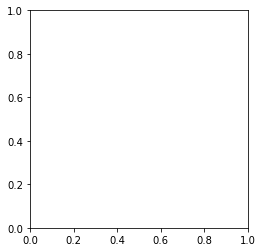

In [94]:
def grid_window(data,
                model,
                weights_dict,
                layer_list,
                im2col_mat,
                step_size,
                h_start,
                w_start):

    
    full = np.empty((1, 1, 6000, 6000))
    count = np.empty((1, 1, 6000, 6000))
    
    # There might be a problem here if we're indexing too many indices if we only have a single image.
    noise_data = data[:, :, h_start:h_start+step_size, w_start:w_start+step_size]   

    # Load the model with corresponding weights, layer lists, and im2col matrices
    # and run inference (ie. denoise the image)
    denoised_img = np_DnCNN(input_data=noise_data, 
                     weights_dict=weights_dict,
                     layer_list=layer_list,
                     im2col_mat=im2col_mat)
        
    # Keep the denoised pixels together + the number of times
    # specific pixels had inference ran on them
    full[:, :, h_start:h_end, w_start:w_end] += denoised_img
    count[:, :, h_start:h_end, w_start:w_end] += 1
        
        
    return full, count

In [ ]:
def grid_window(data,
                model,
                weights_dict,
                layer_list,
                im2col_mat,
                h_start,
                h_end,
                w_start,
                w_end):

    
    full = np.empty((1, 1, 6000, 6000))
    count = np.empty((1, 1, 6000, 6000))
    
    # There might be a problem here if we're indexing too many indices if we only have a single image.
    noise_data = data[:, :, h_start:h_end, w_start:w_end]   

    # Load the model with corresponding weights, layer lists, and im2col matrices
    # and run inference (ie. denoise the image)
    denoised_img = np_DnCNN(input_data=noise_data, 
                     weights_dict=weights_dict,
                     layer_list=layer_list,
                     im2col_mat=im2col_mat)
        
    # Keep the denoised pixels together + the number of times
    # specific pixels had inference ran on them
    full[:, :, h_start:h_end, w_start:w_end] += denoised_img
    count[:, :, h_start:h_end, w_start:w_end] += 1
        
        
    return full, count

In [42]:
img_patch = []
for window in windows:
    img_patch.append(window[-1])

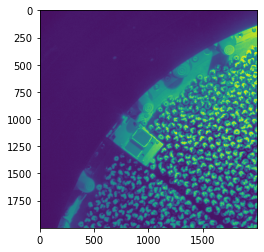

In [46]:
plt.imshow(img_patch[0], origin='upper')

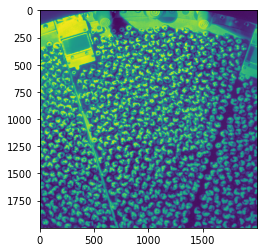

In [47]:
plt.imshow(img_patch[1], origin='upper')

In [45]:
len(img_patch)

9

In [ ]:
window_size=2000
dataset = samp_6k
model=np_DnCNN,
weights_dict=weights
layer_list=im2col_layer_list
im2col_mat=im2col_mat


# inf_patch_size = window_size # 2000
# inf_patch_length = int(len(dataset[0][0][0]) / inf_patch_size) # 3

# window_end_idx = []
# for k in range(inf_patch_length):
#     window_end_idx.append(inf_patch_size*(k))
# window_end_idx.append(len(dataset[0][0][0])) # appends endpt ie. 6k # [0, 2000, 4000, 6000]

# Full image pass
full = np.zeros((1, 1, 6000, 6000))
count = np.zeros((1, 1, 6000, 6000))

# for j in range(len(window_end_idx)-1):
#     for i in range(len(window_end_idx)-1):
#         print('j =', j)
#         print('i =', i)
windows = sliding_window(dataset, stepSize=2000, windowSize=(2000, 2000))
    for window in windows:
        full_c1, count_c1 = grid_window(data=dataset,
                                        model=model, 
                                        weights_dict=weights_dict,
                                        layer_list=layer_list,
                                        im2col_mat=im2col_mat,
                                        
            
            
            (window)
        features.append(featureVector)


full_c1, count_c1 = grid_window(data=dataset,
                                model=model,
                                weights_dict=weights_dict,
                                layer_list=layer_list,
                                im2col_mat=im2col_mat,
                                h_start=window_end_idx[0],
                                h_end=window_end_idx[i+1],
                                w_start=window_end_idx[j],
                                w_end=window_end_idx[j+1])

0
0


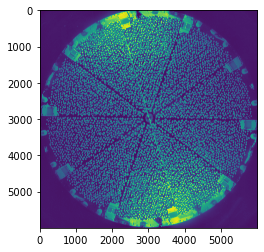

In [37]:
x, y, img = sliding_window(samp_6k, stepSize=2000, windowSize=(2000, 2000))
print(x)
print(y)
plt.imshow(img[0][0], origin='upper')

In [29]:
x, y, img = next(iter(x))

StopIteration: 

In [ ]:
grid_window(data=samp_6k,
                          model=np_DnCNN,
                          weights_dict=weights,
                          layer_list=im2col_layer_list,
                          im2col_mat=im2col_mat,
                          h_start=1000,
                          h_end=3000,
                          w_start=1000,
                          w_end=3000)